<a href="https://colab.research.google.com/github/subikkshas/PREPARE-ALL/blob/main/10_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 19.1 MB/s eta 0:00:00


## Packages

In [2]:
import pandas as pd
import numpy as np
import os
import optuna
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from typing import Dict, List, Tuple, Union
from sklearn.preprocessing import OneHotEncoder
from google.colab import drive
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from xgboost import XGBClassifier

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


## Load data

In [4]:
drive.mount('/content/drive')

# Define the path to the folder in Google Drive
drive_folder_path = '/content/drive/MyDrive/NIR dataset'

# Load the data files
X_train_encoded = pd.read_csv(os.path.join(drive_folder_path, 'X_train_encoded.csv'))
y_train_encoded = pd.read_csv(os.path.join(drive_folder_path, 'y_train_encoded.csv'))
X_test_encoded = pd.read_csv(os.path.join(drive_folder_path, 'X_test_encoded.csv'))
y_test_encoded = pd.read_csv(os.path.join(drive_folder_path, 'y_test_encoded.csv'))

print("Data loaded successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data loaded successfully!


In [5]:
print(X_train_encoded.shape)
print(y_train_encoded.shape)
print(X_test_encoded.shape)
print(y_test_encoded.shape)

(1805, 26)
(1805, 1)
(447, 26)
(447, 1)


## 10 Models

In [9]:
def tune_threshold(model, X_val, y_val, beta = 1):
    y_probs = model.predict_proba(X_val)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_probs)

    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
    #metric = (1 + beta) * (precisions * recalls) / (precisions + (recalls * beta) + 1e-6)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]

    return best_threshold, f1_scores[best_idx]

In [11]:
def evaluate_model(model, X_test, y_test, threshold=0.5):
    # Probabilities
    y_probs = model.predict_proba(X_test)[:, 1]

    # Apply threshold
    y_pred = (y_probs >= threshold).astype(int)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_probs)
    cm = confusion_matrix(y_test, y_pred)

    # Print neatly
    print("=== Evaluation Metrics (Summary) ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC AUC  : {auc:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    return

In [18]:
import joblib
import os

def save_model(model, model_name, folder_path="/content/drive/MyDrive/NIR dataset"):

    # Ensure folder exists
    os.makedirs(folder_path, exist_ok=True)

    # Full path
    save_path = os.path.join(folder_path, model_name)

    # Save with joblib
    joblib.dump(model, save_path)

    print(f"✅ Model saved successfully at: {save_path}")
    return save_path


### XGBoost

In [6]:
def tune_with_optuna_cv(X_train, y_train, n_trials=50, n_splits=5, random_state=42):
    """
    Optuna-tune XGBoost with 5-fold Stratified CV on PR-AUC (Average Precision).
    Handles class imbalance via scale_pos_weight computed per fold.
    Returns: best_model, best_params, best_cv_ap
    """

    # Ensure y is 1-D Series/array
    if isinstance(y_train, pd.DataFrame):
        y_train = y_train.iloc[:, 0]
    y = np.asarray(y_train).reshape(-1)
    X = np.asarray(X_train)

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 150, 900),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0.0, 5.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),

            # fixed settings
            "random_state": random_state,
            "n_jobs": -1,
            "eval_metric": "aucpr",          # track PR-AUC during training logs
            "objective": "binary:logistic",
            "base_score": 0.5, # Set base_score to 0.5 to avoid error with single-class folds
            # tip: you can add tree_method="hist" for speed on CPU
        }

        aps = []
        for tr_idx, va_idx in cv.split(X, y):
            X_tr, X_va = X[tr_idx], X[va_idx]
            y_tr, y_va = y[tr_idx], y[va_idx]

            # scale_pos_weight per fold
            pos = (y_tr == 1).sum()
            neg = (y_tr == 0).sum()
            spw = (neg / max(pos, 1)) if pos > 0 else 1.0

            model = XGBClassifier(**params, scale_pos_weight=spw)
            model.fit(X_tr, y_tr, verbose=False)

            y_va_prob = model.predict_proba(X_va)[:, 1]
            aps.append(average_precision_score(y_va, y_va_prob))

        return float(np.mean(aps))

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    # Train best model on full training data (scale_pos_weight from full y)
    best_params = study.best_params.copy()
    pos_full = int((y == 1).sum())
    neg_full = int((y == 0).sum())
    spw_full = (neg_full / max(pos_full, 1)) if pos_full > 0 else 1.0

    best_model = XGBClassifier(
        **best_params,
        random_state=random_state,
        n_jobs=-1,
        eval_metric="aucpr",
        objective="binary:logistic",
        scale_pos_weight=spw_full,
        base_score=0.5, # Set base_score to 0.5 for the final model as well
    )
    best_model.fit(X, y, verbose=False)

    return best_model, best_params

In [7]:
xgb_model, xgb_params = tune_with_optuna_cv(X_train_encoded, y_train_encoded, n_trials=100)

[I 2025-09-30 05:17:24,207] A new study created in memory with name: no-name-4947d700-a0de-4f4c-9fc7-30bdd5dbd47d
[I 2025-09-30 05:17:24,549] Trial 0 finished with value: 0.37819495877887366 and parameters: {'n_estimators': 227, 'max_depth': 11, 'learning_rate': 0.04836040972851203, 'subsample': 0.9661460310868659, 'colsample_bytree': 0.7790343845443126, 'gamma': 4.747437465870954, 'reg_lambda': 0.001004194544765785, 'reg_alpha': 3.91257248745895, 'min_child_weight': 3}. Best is trial 0 with value: 0.37819495877887366.
[I 2025-09-30 05:17:25,157] Trial 1 finished with value: 0.38500070307901313 and parameters: {'n_estimators': 625, 'max_depth': 3, 'learning_rate': 0.049663968378914604, 'subsample': 0.8475094783690877, 'colsample_bytree': 0.6536050064551107, 'gamma': 4.39588274748454, 'reg_lambda': 4.422689356156948, 'reg_alpha': 0.04556956170238324, 'min_child_weight': 4}. Best is trial 1 with value: 0.38500070307901313.
[I 2025-09-30 05:17:25,961] Trial 2 finished with value: 0.380508

In [8]:
print(xgb_params)

{'n_estimators': 747, 'max_depth': 4, 'learning_rate': 0.03242751325516819, 'subsample': 0.5423602608665311, 'colsample_bytree': 0.6297592020433863, 'gamma': 4.474549328016174, 'reg_lambda': 0.0025758141686004613, 'reg_alpha': 0.1123140316513936, 'min_child_weight': 6}


In [10]:
xgb_threshold, xgb_f1 = tune_threshold(xgb_model, X_train_encoded, y_train_encoded, 0.1)
print(f"Best Threshold: {xgb_threshold}")
print(f"Best F1 Score: {xgb_f1}")

Best Threshold: 0.49007168412208557
Best F1 Score: 0.5651461137575594


In [13]:
# 100 trials
evaluate_model(xgb_model, X_test_encoded, y_test_encoded, xgb_threshold)

=== Evaluation Metrics (Summary) ===
Accuracy : 0.5973
Precision: 0.3194
Recall   : 0.5495
F1-score : 0.4040
ROC AUC  : 0.6321

Confusion Matrix:
[[206 130]
 [ 50  61]]


In [14]:
evaluate_model(xgb_model, X_test_encoded, y_test_encoded, threshold = 0.450)

=== Evaluation Metrics (Summary) ===
Accuracy : 0.5615
Precision: 0.3128
Recall   : 0.6396
F1-score : 0.4201
ROC AUC  : 0.6321

Confusion Matrix:
[[180 156]
 [ 40  71]]


In [17]:
evaluate_model(xgb_model, X_test_encoded, y_test_encoded, threshold = 0.437)

=== Evaluation Metrics (Summary) ===
Accuracy : 0.5481
Precision: 0.3128
Recall   : 0.6847
F1-score : 0.4294
ROC AUC  : 0.6321

Confusion Matrix:
[[169 167]
 [ 35  76]]


In [16]:
evaluate_model(xgb_model, X_test_encoded, y_test_encoded, threshold = 0.425)

=== Evaluation Metrics (Summary) ===
Accuracy : 0.5324
Precision: 0.3071
Recall   : 0.7027
F1-score : 0.4274
ROC AUC  : 0.6321

Confusion Matrix:
[[160 176]
 [ 33  78]]


In [15]:
evaluate_model(xgb_model, X_test_encoded, y_test_encoded, threshold = 0.40)

=== Evaluation Metrics (Summary) ===
Accuracy : 0.5145
Precision: 0.3022
Recall   : 0.7297
F1-score : 0.4274
ROC AUC  : 0.6321

Confusion Matrix:
[[149 187]
 [ 30  81]]


In [ ]:
# Best threshold = 0.437
# Best params
# {'n_estimators': 747, 'max_depth': 4, 'learning_rate': 0.03242751325516819, 'subsample': 0.5423602608665311, 'colsample_bytree': 0.6297592020433863, 'gamma': 4.474549328016174, 'reg_lambda': 0.0025758141686004613, 'reg_alpha': 0.1123140316513936, 'min_child_weight': 6}

In [19]:
save_model(xgb_model, "xgb_model.joblib")

✅ Model saved successfully at: /content/drive/MyDrive/NIR dataset/xgb_model.joblib


'/content/drive/MyDrive/NIR dataset/xgb_model.joblib'

### Random Forest

In [20]:
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score
from sklearn.ensemble import RandomForestClassifier

# === 5-fold CV objective for Random Forest (maximize PR-AUC) ===
def rf_objective(trial):
    # Make sure we have numpy arrays for indexing
    X = np.asarray(X_train_encoded)
    y = y_train_encoded.values.ravel() if hasattr(y_train_encoded, "values") else np.asarray(y_train_encoded).ravel()

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 800),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "class_weight": "balanced",       # handle imbalance
        "n_jobs": -1,                     # speed
        "random_state": 42
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    ap_scores = []
    for tr_idx, va_idx in skf.split(X, y):
        X_tr, X_va = X[tr_idx], X[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]

        model = RandomForestClassifier(**params)
        model.fit(X_tr, y_tr)

        y_va_prob = model.predict_proba(X_va)[:, 1]
        ap_scores.append(average_precision_score(y_va, y_va_prob))

    return float(np.mean(ap_scores))

In [21]:
study = optuna.create_study(direction="maximize")
study.optimize(rf_objective, n_trials=60)

best_params = study.best_params
best_rf = RandomForestClassifier(**best_params)
best_rf.fit(np.asarray(X_train_encoded), (y_train_encoded.values.ravel()
                                  if hasattr(y_train_encoded, "values") else np.asarray(y_train_encoded).ravel()))
print("Best params:", best_params)
print("Best mean CV PR-AUC:", study.best_value)

[I 2025-09-30 05:35:15,326] A new study created in memory with name: no-name-d2aa7267-edd2-4bfd-862b-bad4eaa21297
[I 2025-09-30 05:35:22,526] Trial 0 finished with value: 0.3820014934581554 and parameters: {'n_estimators': 525, 'max_depth': 13, 'min_samples_split': 11, 'min_samples_leaf': 6, 'bootstrap': False, 'criterion': 'entropy'}. Best is trial 0 with value: 0.3820014934581554.
[I 2025-09-30 05:35:26,833] Trial 1 finished with value: 0.394978397901757 and parameters: {'n_estimators': 255, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 15, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 1 with value: 0.394978397901757.
[I 2025-09-30 05:35:28,772] Trial 2 finished with value: 0.39671952204221345 and parameters: {'n_estimators': 147, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 19, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 2 with value: 0.39671952204221345.
[I 2025-09-30 05:35:31,866] Trial 3 finished with value: 0.390322782825

Best params: {'n_estimators': 532, 'max_depth': 18, 'min_samples_split': 20, 'min_samples_leaf': 19, 'bootstrap': True, 'criterion': 'entropy'}
Best mean CV PR-AUC: 0.4003225246914499


In [22]:
best_threshold_rf, best_f1_rf = tune_threshold(best_rf, X_train_encoded, y_train_encoded, beta=1)
print(f"Best Threshold (Random Forest): {best_threshold_rf}")
print(f"Best F1-Score (Random Forest): {best_f1_rf}")

evaluate_model(best_rf, X_test_encoded, y_test_encoded.values.ravel(), best_threshold_rf)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Best Threshold (Random Forest): 0.2768218914742951
Best F1-Score (Random Forest): 0.5430706722710567
=== Evaluation Metrics (Summary) ===
Accuracy : 0.6331
Precision: 0.3172
Recall   : 0.4144
F1-score : 0.3594
ROC AUC  : 0.6147

Confusion Matrix:
[[237  99]
 [ 65  46]]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [49]:
save_model(best_rf, "rf_model.joblib")

✅ Model saved successfully at: /content/drive/MyDrive/NIR dataset/rf_model.joblib


'/content/drive/MyDrive/NIR dataset/rf_model.joblib'

### Gradient Boosting

In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import average_precision_score
import optuna

def gb_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 800),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "max_features": trial.suggest_float("max_features", 0.5, 1.0),
        "random_state": 42,
    }

    # Ensure y_train is a Series, not DataFrame
    if isinstance(y_train_encoded, pd.DataFrame):
        y_train_series = y_train_encoded.iloc[:, 0]
    else:
        y_train_series = y_train_encoded

    # (Optional) class ratio info; GB doesn't have scale_pos_weight
    pos = int((y_train_series == 1).sum())
    neg = int((y_train_series == 0).sum())
    scale_pos_weight = (neg / pos) if pos > 0 else 1  # not used directly by GB

    # Arrays for CV
    X = np.asarray(X_train_encoded)
    y = np.asarray(y_train_series).ravel()

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    ap_scores = []
    for tr_idx, va_idx in skf.split(X, y):
        X_tr, X_va = X[tr_idx], X[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]

        model = GradientBoostingClassifier(**params)
        model.fit(X_tr, y_tr)

        y_va_prob = model.predict_proba(X_va)[:, 1]
        ap_scores.append(average_precision_score(y_va, y_va_prob))

    return float(np.mean(ap_scores))


In [24]:
study_gb = optuna.create_study(direction="maximize")
study_gb.optimize(gb_objective, n_trials=50)

best_model_gb = GradientBoostingClassifier(**study_gb.best_params)
# Ensure y_train is a Series, not DataFrame for fitting
if isinstance(y_train_encoded, pd.DataFrame):
    y_train_series = y_train_encoded.iloc[:, 0]
else:
    y_train_series = y_train_encoded
best_model_gb.fit(X_train_encoded, y_train_series.values.ravel())

[I 2025-09-30 05:44:43,171] A new study created in memory with name: no-name-7e2db8dd-993e-4d02-ae8f-8518af6b61f2
[I 2025-09-30 05:45:04,388] Trial 0 finished with value: 0.32979665288143833 and parameters: {'n_estimators': 617, 'learning_rate': 0.05679856341539961, 'max_depth': 7, 'min_samples_split': 12, 'min_samples_leaf': 4, 'subsample': 0.5560401957056302, 'max_features': 0.5852309540821687}. Best is trial 0 with value: 0.32979665288143833.
[I 2025-09-30 05:45:56,272] Trial 1 finished with value: 0.34445545269423083 and parameters: {'n_estimators': 791, 'learning_rate': 0.012495779751275334, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 1, 'subsample': 0.5710705431756407, 'max_features': 0.8829103943301394}. Best is trial 1 with value: 0.34445545269423083.
[I 2025-09-30 05:46:12,088] Trial 2 finished with value: 0.3299741627716032 and parameters: {'n_estimators': 621, 'learning_rate': 0.1395110745834878, 'max_depth': 4, 'min_samples_split': 13, 'min_samples_leaf': 12

GradientBoostingClassifier(learning_rate=0.011238450547271782, max_depth=8,
                           max_features=0.5052143945079866, min_samples_leaf=18,
                           subsample=0.5717230792982385)

In [25]:
# Ensure y_test is a Series
if isinstance(y_test_encoded, pd.DataFrame):
    y_test_series = y_test_encoded.iloc[:, 0]
else:
    y_test_series = y_test_encoded

# Ensure y_train is a Series
if isinstance(y_train_encoded, pd.DataFrame):
    y_train_series = y_train_encoded.iloc[:, 0]
else:
    y_train_series = y_train_encoded

# Find the best threshold for Gradient Boosting
best_threshold_gb, best_f1_gb = tune_threshold(best_model_gb, X_train_encoded, y_train_series, beta=1)

# Print the best threshold and F1-score
print(f"Best Threshold (Gradient Boosting): {best_threshold_gb}")
print(f"Best F1-Score (Gradient Boosting): {best_f1_gb}")

# Evaluate the model on the test set
print("\nEvaluation on Test Set:")
evaluate_model(best_model_gb, X_test_encoded, y_test_series, best_threshold_gb)

Best Threshold (Gradient Boosting): 0.264699278250396
Best F1-Score (Gradient Boosting): 0.5767190965791319

Evaluation on Test Set:
=== Evaluation Metrics (Summary) ===
Accuracy : 0.5951
Precision: 0.2941
Recall   : 0.4505
F1-score : 0.3559
ROC AUC  : 0.6166

Confusion Matrix:
[[216 120]
 [ 61  50]]


In [50]:
save_model(best_model_gb, "gb_model.joblib")

✅ Model saved successfully at: /content/drive/MyDrive/NIR dataset/gb_model.joblib


'/content/drive/MyDrive/NIR dataset/gb_model.joblib'

### Logistic Regression

In [26]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
import optuna

def lr_objective(trial):
    params = {
        "C": trial.suggest_float("C", 1e-4, 1e4, log=True),
        "solver": trial.suggest_categorical("solver", ["liblinear", "lbfgs", "saga"]),
        "penalty": trial.suggest_categorical("penalty", ["l2", "l1", "elasticnet"]),
        "class_weight": "balanced",
        "random_state": 42,
        "max_iter": 2000,  # helps convergence for saga/liblinear with class_weight
    }

    # ---- Handle incompatible solver/penalty combos ----
    # l1 only with liblinear or saga
    if params["penalty"] == "l1" and params["solver"] not in ["liblinear", "saga"]:
        raise optuna.exceptions.TrialPruned()
    # elasticnet only with saga (and requires l1_ratio)
    if params["penalty"] == "elasticnet" and params["solver"] != "saga":
        raise optuna.exceptions.TrialPruned()
    # 'none' penalty not supported by liblinear
    if params["penalty"] == "none" and params["solver"] == "liblinear":
        raise optuna.exceptions.TrialPruned()

    extra_kwargs = {}
    if params["penalty"] == "elasticnet":
        extra_kwargs["l1_ratio"] = trial.suggest_float("l1_ratio", 0.0, 1.0)

    # ---- Ensure y_train is a Series, not DataFrame ----
    if isinstance(y_train_encoded, pd.DataFrame):
        y_train_series = y_train_encoded.iloc[:, 0]
    else:
        y_train_series = y_train_encoded

    # ---- 5-fold Stratified CV on PR-AUC ----
    X = np.asarray(X_train_encoded)
    y = np.asarray(y_train_series).ravel()

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    ap_scores = []
    for tr_idx, va_idx in skf.split(X, y):
        X_tr, X_va = X[tr_idx], X[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]

        model = LogisticRegression(**params, **extra_kwargs)
        model.fit(X_tr, y_tr)

        y_va_prob = model.predict_proba(X_va)[:, 1]
        ap_scores.append(average_precision_score(y_va, y_va_prob))

    return float(np.mean(ap_scores))

In [27]:
# === Run Optuna study for Logistic Regression ===
study = optuna.create_study(direction="maximize")
study.optimize(lr_objective, n_trials=50)   # increase n_trials for a more thorough search

# === Extract best hyperparameters and fit final model ===
best_params = study.best_params.copy()

# Handle l1_ratio if elasticnet was selected
extra_kwargs = {}
if best_params.get("penalty") == "elasticnet":
    # optuna may have produced l1_ratio as part of best_params; keep it
    if "l1_ratio" in best_params:
        extra_kwargs["l1_ratio"] = best_params.pop("l1_ratio")

from sklearn.linear_model import LogisticRegression
final_lr = LogisticRegression(**best_params, **extra_kwargs, max_iter=2000)
final_lr.fit(X_train_encoded, y_train_encoded.values.ravel() if hasattr(y_train_encoded, "values") else y_train_encoded)

print("Best Logistic Regression Parameters:", best_params)
print("Best CV PR-AUC:", study.best_value)




[I 2025-09-30 06:02:46,233] A new study created in memory with name: no-name-98fed540-21b3-41e7-8f49-ac12aa774f73
[I 2025-09-30 06:02:46,240] Trial 0 pruned. 
[I 2025-09-30 06:02:46,243] Trial 1 pruned. 
[I 2025-09-30 06:02:46,274] Trial 2 finished with value: 0.32820796455265855 and parameters: {'C': 192.13191074468136, 'solver': 'liblinear', 'penalty': 'l2'}. Best is trial 2 with value: 0.32820796455265855.
[I 2025-09-30 06:02:46,363] Trial 3 finished with value: 0.32830220827389966 and parameters: {'C': 0.0001102561153848369, 'solver': 'saga', 'penalty': 'l1'}. Best is trial 3 with value: 0.32830220827389966.
[I 2025-09-30 06:02:46,393] Trial 4 finished with value: 0.32820796455265855 and parameters: {'C': 0.48270880837871616, 'solver': 'liblinear', 'penalty': 'l2'}. Best is trial 3 with value: 0.32830220827389966.
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Best Logistic Regression Parameters: {'C': 2.5332314324655947, 'solver': 'lbfgs', 'penalty': 'l2'}
Best CV PR-AUC: 0.38875328010580285


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [28]:
# Ensure y_test is a Series
if isinstance(y_test_encoded, pd.DataFrame):
    y_test_series = y_test_encoded.iloc[:, 0]
else:
    y_test_series = y_test_encoded

# Ensure y_train is a Series
if isinstance(y_train_encoded, pd.DataFrame):
    y_train_series = y_train_encoded.iloc[:, 0]
else:
    y_train_series = y_train_encoded

# Find the best threshold for Logistic Regression
best_threshold_lr, best_f1_lr = tune_threshold(final_lr, X_train_encoded, y_train_series, beta=1)

# Print the best threshold and F1-score
print(f"Best Threshold (Logistic Regression): {best_threshold_lr}")
print(f"Best F1-Score (Logistic Regression): {best_f1_lr}")

# Evaluate the model on the test set
print("\nEvaluation on Test Set:")
evaluate_model(final_lr, X_test_encoded, y_test_series, best_threshold_lr)

Best Threshold (Logistic Regression): 0.21273473771406137
Best F1-Score (Logistic Regression): 0.4606216841967097

Evaluation on Test Set:
=== Evaluation Metrics (Summary) ===
Accuracy : 0.5011
Precision: 0.2879
Recall   : 0.6847
F1-score : 0.4053
ROC AUC  : 0.5953

Confusion Matrix:
[[148 188]
 [ 35  76]]


In [51]:
save_model(final_lr, "lr_model.joblib")

✅ Model saved successfully at: /content/drive/MyDrive/NIR dataset/lr_model.joblib


'/content/drive/MyDrive/NIR dataset/lr_model.joblib'

### Catboost

In [29]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score
from catboost import CatBoostClassifier
import optuna

def catboost_objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 800),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.01, 10),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "random_state": 42,
        "verbose": 0,  # suppress training logs during tuning
        # (optional, uncomment if you want CatBoost to track it)
        # "eval_metric": "PRAUC",
        # "loss_function": "Logloss",
    }

    # Ensure y_train is a Series, not DataFrame
    if isinstance(y_train_encoded, pd.DataFrame):
        y_train_series = y_train_encoded.iloc[:, 0]
    else:
        y_train_series = y_train_encoded

    # Arrays for CV
    X = X_train_encoded  # keep as DataFrame if you’re using CatBoost (it handles pandas nicely)
    y = np.asarray(y_train_series).ravel()

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    ap_scores = []
    for tr_idx, va_idx in skf.split(X, y):
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx] if hasattr(X, "iloc") else (X[tr_idx], X[va_idx])
        y_tr, y_va = y[tr_idx], y[va_idx]

        # Per-fold class imbalance handling
        pos = int((y_tr == 1).sum())
        neg = int((y_tr == 0).sum())
        spw = (neg / max(pos, 1)) if pos > 0 else 1.0

        model = CatBoostClassifier(**params, scale_pos_weight=spw)
        model.fit(X_tr, y_tr)

        y_va_prob = model.predict_proba(X_va)[:, 1]
        ap_scores.append(average_precision_score(y_va, y_va_prob))

    return float(np.mean(ap_scores))


In [31]:
study_catboost = optuna.create_study(direction="maximize")
study_catboost.optimize(catboost_objective, n_trials=50)

best_model_catboost = CatBoostClassifier(**study_catboost.best_params)

# Ensure y_train is a Series, not DataFrame for fitting
if isinstance(y_train_encoded, pd.DataFrame):
    y_train_series = y_train_encoded.iloc[:, 0]
else:
    y_train_series = y_train_encoded

best_model_catboost.fit(X_train_encoded, y_train_series.values.ravel(), verbose=0) # Suppress verbose output during final training

[I 2025-09-30 06:04:59,636] A new study created in memory with name: no-name-b9f425e9-44c2-4d22-8bf3-f5d5c98c58b1
[I 2025-09-30 06:05:02,564] Trial 0 finished with value: 0.352514130101523 and parameters: {'iterations': 303, 'learning_rate': 0.11680793650897006, 'depth': 6, 'l2_leaf_reg': 0.5325112557848403, 'border_count': 166, 'subsample': 0.8179114003395598}. Best is trial 0 with value: 0.352514130101523.
[I 2025-09-30 06:05:09,108] Trial 1 finished with value: 0.33805452161890714 and parameters: {'iterations': 679, 'learning_rate': 0.18417469525318803, 'depth': 6, 'l2_leaf_reg': 6.821220759191585, 'border_count': 141, 'subsample': 0.5061149908090425}. Best is trial 0 with value: 0.352514130101523.
[I 2025-09-30 06:05:14,093] Trial 2 finished with value: 0.3381786827265429 and parameters: {'iterations': 579, 'learning_rate': 0.08277580643310913, 'depth': 7, 'l2_leaf_reg': 7.912000394339624, 'border_count': 67, 'subsample': 0.8138523601354248}. Best is trial 0 with value: 0.352514130

In [32]:
# Ensure y_test is a Series
if isinstance(y_test_encoded, pd.DataFrame):
    y_test_series = y_test_encoded.iloc[:, 0]
else:
    y_test_series = y_test_encoded

# Ensure y_train is a Series
if isinstance(y_train_encoded, pd.DataFrame):
    y_train_series = y_train_encoded.iloc[:, 0]
else:
    y_train_series = y_train_encoded

# Find the best threshold for CatBoost
best_threshold_catboost, best_f1_catboost = tune_threshold(best_model_catboost, X_train_encoded, y_train_series, beta=1)

# Print the best threshold and F1-score
print(f"Best Threshold (CatBoost): {best_threshold_catboost}")
print(f"Best F1-Score (CatBoost): {best_f1_catboost}")

# Evaluate the model on the test set
print("\nEvaluation on Test Set:")
evaluate_model(best_model_catboost, X_test_encoded, y_test_series, best_threshold_catboost)


Best Threshold (CatBoost): 0.28435895206403794
Best F1-Score (CatBoost): 0.5314280805736961

Evaluation on Test Set:
=== Evaluation Metrics (Summary) ===
Accuracy : 0.6286
Precision: 0.3129
Recall   : 0.4144
F1-score : 0.3566
ROC AUC  : 0.6279

Confusion Matrix:
[[235 101]
 [ 65  46]]


In [52]:
save_model(best_model_catboost, "catboost_model.joblib")

✅ Model saved successfully at: /content/drive/MyDrive/NIR dataset/catboost_model.joblib


'/content/drive/MyDrive/NIR dataset/catboost_model.joblib'

### AdaBoost

In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import average_precision_score
import optuna

def adaboost_objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0),
        "random_state": 42,
    }

    # Ensure y_train is a Series, not DataFrame
    if isinstance(y_train_encoded, pd.DataFrame):
        y_train_series = y_train_encoded.iloc[:, 0]
    else:
        y_train_series = y_train_encoded

    # Arrays for 5-fold CV
    X = np.asarray(X_train_encoded)
    y = np.asarray(y_train_series).ravel()

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    ap_scores = []
    for tr_idx, va_idx in skf.split(X, y):
        X_tr, X_va = X[tr_idx], X[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]

        model = AdaBoostClassifier(**params)
        model.fit(X_tr, y_tr)

        y_va_prob = model.predict_proba(X_va)[:, 1]
        ap_scores.append(average_precision_score(y_va, y_va_prob))

    return float(np.mean(ap_scores))


In [34]:
study_adaboost = optuna.create_study(direction="maximize")
study_adaboost.optimize(adaboost_objective, n_trials=50)

best_model_adaboost = AdaBoostClassifier(**study_adaboost.best_params)
# Ensure y_train is a Series, not DataFrame for fitting
if isinstance(y_train_encoded, pd.DataFrame):
    y_train_series = y_train_encoded.iloc[:, 0]
else:
    y_train_series = y_train_encoded
best_model_adaboost.fit(X_train_encoded, y_train_series.values.ravel())

[I 2025-09-30 06:08:03,447] A new study created in memory with name: no-name-07d1947a-dd34-4832-b757-3dd24f3a366a
[I 2025-09-30 06:08:08,357] Trial 0 finished with value: 0.39558093750073137 and parameters: {'n_estimators': 276, 'learning_rate': 0.27800731152081415}. Best is trial 0 with value: 0.39558093750073137.
[I 2025-09-30 06:08:11,753] Trial 1 finished with value: 0.38731554510434957 and parameters: {'n_estimators': 208, 'learning_rate': 0.09496712419521142}. Best is trial 0 with value: 0.39558093750073137.
[I 2025-09-30 06:08:14,379] Trial 2 finished with value: 0.3875130193935507 and parameters: {'n_estimators': 186, 'learning_rate': 0.5717872479947076}. Best is trial 0 with value: 0.39558093750073137.
[I 2025-09-30 06:08:16,828] Trial 3 finished with value: 0.3891661757224114 and parameters: {'n_estimators': 179, 'learning_rate': 0.7525047628920967}. Best is trial 0 with value: 0.39558093750073137.
[I 2025-09-30 06:08:21,522] Trial 4 finished with value: 0.39183301305608137 a

AdaBoostClassifier(learning_rate=0.35206176697649527, n_estimators=466)

In [35]:
# Ensure y_test is a Series
if isinstance(y_test_encoded, pd.DataFrame):
    y_test_series = y_test_encoded.iloc[:, 0]
else:
    y_test_series = y_test_encoded

# Ensure y_train is a Series
if isinstance(y_train_encoded, pd.DataFrame):
    y_train_series = y_train_encoded.iloc[:, 0]
else:
    y_train_series = y_train_encoded

# Find the best threshold for AdaBoost
best_threshold_adaboost, best_f1_adaboost = tune_threshold(best_model_adaboost, X_train_encoded, y_train_series, beta=1)

# Print the best threshold and F1-score
print(f"Best Threshold (AdaBoost): {best_threshold_adaboost}")
print(f"Best F1-Score (AdaBoost): {best_f1_adaboost}")

# Evaluate the model on the test set
print("\nEvaluation on Test Set:")
evaluate_model(best_model_adaboost, X_test_encoded, y_test_series, best_threshold_adaboost)


Best Threshold (AdaBoost): 0.36120434585084993
Best F1-Score (AdaBoost): 0.4680846849009284

Evaluation on Test Set:
=== Evaluation Metrics (Summary) ===
Accuracy : 0.5101
Precision: 0.2923
Recall   : 0.6847
F1-score : 0.4097
ROC AUC  : 0.6475

Confusion Matrix:
[[152 184]
 [ 35  76]]


In [48]:
best_threshold_adaboost = 0.39
evaluate_model(best_model_adaboost, X_test_encoded, y_test_series, best_threshold_adaboost)

=== Evaluation Metrics (Summary) ===
Accuracy : 0.6242
Precision: 0.3459
Recall   : 0.5766
F1-score : 0.4324
ROC AUC  : 0.6475

Confusion Matrix:
[[215 121]
 [ 47  64]]


In [53]:
save_model(best_model_adaboost, "adaboost_model.joblib")

✅ Model saved successfully at: /content/drive/MyDrive/NIR dataset/adaboost_model.joblib


'/content/drive/MyDrive/NIR dataset/adaboost_model.joblib'

### Decision Tree

In [36]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import average_precision_score
import optuna
import pandas as pd

def dt_objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "random_state": 42,
        "class_weight": "balanced",  # handle class imbalance
    }

    # Ensure y_train is a Series, not DataFrame
    if isinstance(y_train_encoded, pd.DataFrame):
        y_train_series = y_train_encoded.iloc[:, 0]
    else:
        y_train_series = y_train_encoded

    # Arrays for 5-fold CV
    X = np.asarray(X_train_encoded)
    y = np.asarray(y_train_series).ravel()

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    ap_scores = []
    for tr_idx, va_idx in skf.split(X, y):
        X_tr, X_va = X[tr_idx], X[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]

        model = DecisionTreeClassifier(**params)
        model.fit(X_tr, y_tr)

        y_va_prob = model.predict_proba(X_va)[:, 1]
        ap_scores.append(average_precision_score(y_va, y_va_prob))

    return float(np.mean(ap_scores))


In [37]:
study_dt = optuna.create_study(direction="maximize")
study_dt.optimize(dt_objective, n_trials=50)

best_model_dt = DecisionTreeClassifier(**study_dt.best_params)
# Ensure y_train is a Series, not DataFrame for fitting
if isinstance(y_train_encoded, pd.DataFrame):
    y_train_series = y_train_encoded.iloc[:, 0]
else:
    y_train_series = y_train_encoded
best_model_dt.fit(X_train_encoded, y_train_series.values.ravel())

[I 2025-09-30 06:13:10,664] A new study created in memory with name: no-name-468114d0-4a91-434f-af8c-8d092108ff23
[I 2025-09-30 06:13:10,707] Trial 0 finished with value: 0.3145901432643149 and parameters: {'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 20, 'criterion': 'entropy'}. Best is trial 0 with value: 0.3145901432643149.
[I 2025-09-30 06:13:10,748] Trial 1 finished with value: 0.3462338921175973 and parameters: {'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 18, 'criterion': 'gini'}. Best is trial 1 with value: 0.3462338921175973.
[I 2025-09-30 06:13:10,778] Trial 2 finished with value: 0.30580146288400634 and parameters: {'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 11, 'criterion': 'gini'}. Best is trial 1 with value: 0.3462338921175973.
[I 2025-09-30 06:13:10,825] Trial 3 finished with value: 0.31284122830733213 and parameters: {'max_depth': 16, 'min_samples_split': 16, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 1

DecisionTreeClassifier(max_depth=16, min_samples_leaf=19, min_samples_split=8)

In [38]:
# Ensure y_test is a Series
if isinstance(y_test_encoded, pd.DataFrame):
    y_test_series = y_test_encoded.iloc[:, 0]
else:
    y_test_series = y_test_encoded

# Ensure y_train is a Series
if isinstance(y_train_encoded, pd.DataFrame):
    y_train_series = y_train_encoded.iloc[:, 0]
else:
    y_train_series = y_train_encoded

# Find the best threshold for Decision Tree
best_threshold_dt, best_f1_dt = tune_threshold(best_model_dt, X_train_encoded, y_train_series, beta=1)

# Print the best threshold and F1-score
print(f"Best Threshold (Decision Tree): {best_threshold_dt}")
print(f"Best F1-Score (Decision Tree): {best_f1_dt}")

# Evaluate the model on the test set
print("\nEvaluation on Test Set:")
evaluate_model(best_model_dt, X_test_encoded, y_test_series, best_threshold_dt)


Best Threshold (Decision Tree): 0.2857142857142857
Best F1-Score (Decision Tree): 0.5491868645311564

Evaluation on Test Set:
=== Evaluation Metrics (Summary) ===
Accuracy : 0.5772
Precision: 0.2880
Recall   : 0.4775
F1-score : 0.3593
ROC AUC  : 0.5961

Confusion Matrix:
[[205 131]
 [ 58  53]]


In [54]:
save_model(best_model_dt, "dt_model.joblib")

✅ Model saved successfully at: /content/drive/MyDrive/NIR dataset/dt_model.joblib


'/content/drive/MyDrive/NIR dataset/dt_model.joblib'

### SVM

In [39]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

def svm_objective(trial):
    params = {
        "C": trial.suggest_float("C", 0.1, 10.0, log=True),
        "kernel": trial.suggest_categorical("kernel", ["linear", "rbf", "poly"]),
        "gamma": trial.suggest_categorical("gamma", ["scale", "auto"]),
        "probability": True,  # Required for predict_proba
        "random_state": 42,
        "class_weight": "balanced",  # handle class imbalance
    }

    # Add degree parameter for poly kernel
    if params["kernel"] == "poly":
        params["degree"] = trial.suggest_int("degree", 2, 5)

    # Ensure y_train is a Series, not DataFrame
    if isinstance(y_train_encoded, pd.DataFrame):
        y_train_series = y_train_encoded.iloc[:, 0]
    else:
        y_train_series = y_train_encoded

    # Arrays for 5-fold CV
    X = np.asarray(X_train_encoded)
    y = np.asarray(y_train_series).ravel()

    # Scale features for SVM
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    ap_scores = []
    for tr_idx, va_idx in skf.split(X_scaled, y):
        X_tr, X_va = X_scaled[tr_idx], X_scaled[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]

        model = SVC(**params)
        model.fit(X_tr, y_tr)

        y_va_prob = model.predict_proba(X_va)[:, 1]
        ap_scores.append(average_precision_score(y_va, y_va_prob))

    return float(np.mean(ap_scores))

# Optimize SVM
study_svm = optuna.create_study(direction="maximize")
study_svm.optimize(svm_objective, n_trials=50)

# Train best SVM model with scaling
best_params_svm = study_svm.best_params.copy()
best_params_svm.update({
    "probability": True,
    "random_state": 42,
    "class_weight": "balanced"
})

# Scale features
scaler_svm = StandardScaler()
X_train_scaled = scaler_svm.fit_transform(X_train_encoded)

best_model_svm = SVC(**best_params_svm)
if isinstance(y_train_encoded, pd.DataFrame):
    y_train_series = y_train_encoded.iloc[:, 0]
else:
    y_train_series = y_train_encoded

best_model_svm.fit(X_train_scaled, y_train_series.values.ravel())

# Find best threshold for SVM
X_train_scaled_threshold = scaler_svm.transform(X_train_encoded)
best_threshold_svm, best_f1_svm = tune_threshold(best_model_svm, X_train_scaled_threshold, y_train_series, beta=1)

print(f"Best Threshold (SVM): {best_threshold_svm}")
print(f"Best F1-Score (SVM): {best_f1_svm}")

# Evaluate on test set
X_test_scaled = scaler_svm.transform(X_test_encoded)
if isinstance(y_test_encoded, pd.DataFrame):
    y_test_series = y_test_encoded.iloc[:, 0]
else:
    y_test_series = y_test_encoded

print("\nEvaluation on Test Set (SVM):")
evaluate_model(best_model_svm, X_test_scaled, y_test_series, best_threshold_svm)

[I 2025-09-30 06:13:13,097] A new study created in memory with name: no-name-19eb9b45-c282-40c5-9af8-04af69de3293
[I 2025-09-30 06:13:17,846] Trial 0 finished with value: 0.3781013064253973 and parameters: {'C': 0.4251988927155087, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.3781013064253973.
[I 2025-09-30 06:13:26,821] Trial 1 finished with value: 0.3676108534904008 and parameters: {'C': 7.9471284913582645, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.3781013064253973.
[I 2025-09-30 06:13:31,186] Trial 2 finished with value: 0.3433405259530883 and parameters: {'C': 1.4554932766777002, 'kernel': 'poly', 'gamma': 'scale', 'degree': 5}. Best is trial 0 with value: 0.3781013064253973.
[I 2025-09-30 06:13:34,225] Trial 3 finished with value: 0.3397964263201123 and parameters: {'C': 4.3697638205300695, 'kernel': 'poly', 'gamma': 'scale', 'degree': 5}. Best is trial 0 with value: 0.3781013064253973.
[I 2025-09-30 06:13:36,897] Trial 4 finished wit

Best Threshold (SVM): 0.26013916252818936
Best F1-Score (SVM): 0.5035512370648988

Evaluation on Test Set (SVM):
=== Evaluation Metrics (Summary) ===
Accuracy : 0.5839
Precision: 0.3116
Recall   : 0.5586
F1-score : 0.4000
ROC AUC  : 0.5905

Confusion Matrix:
[[199 137]
 [ 49  62]]


In [55]:
save_model(best_model_svm, "svm_model.joblib")

✅ Model saved successfully at: /content/drive/MyDrive/NIR dataset/svm_model.joblib


'/content/drive/MyDrive/NIR dataset/svm_model.joblib'

### KNN

In [57]:
# === Imbalance-aware KNN: Optuna tune on PR-AUC, OOF Fβ threshold, save to Drive ===
from google.colab import drive
drive.mount('/content/drive')

import os, json, joblib, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import (
    average_precision_score, roc_auc_score, accuracy_score,
    precision_recall_fscore_support, classification_report,
    precision_recall_curve
)
import optuna


# NOTE: KNN does NOT support class_weight/sample_weight.
# We address imbalance by tuning for PR-AUC and by Fβ threshold tuning.
BETA = 2.0  # >1 favors recall, 1=F1, <1 favors precision

# Ensure arrays are correct shapes (1-D targets)
Xtr = np.asarray(X_train_encoded)
Xte = np.asarray(X_test_encoded)
ytr = np.asarray(y_train_encoded).astype(int).reshape(-1)
yte = np.asarray(y_test_encoded).astype(int).reshape(-1)

print("Class distribution (train):", dict(zip(*np.unique(ytr, return_counts=True))))
print("Class distribution (test) :", dict(zip(*np.unique(yte, return_counts=True))))

# ---------------- Threshold tuners ----------------
def tune_threshold_from_scores(y_true, y_scores, beta=1.0):
    """Tune threshold directly from score vector using Fβ in PR space (for OOF)."""
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
    metric = (1 + beta) * (precisions * recalls) / (precisions + (recalls * beta) + 1e-6)
    best_idx = int(np.argmax(metric))
    if best_idx >= len(thresholds):  # last PR point has no threshold
        best_idx = len(thresholds) - 1
    return float(thresholds[max(best_idx, 0)]), float(metric[best_idx])

# ---------------- Model builder ----------------
def build_knn(n_neighbors, weights, leaf_size, p, algorithm):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(
            n_neighbors=n_neighbors,
            weights=weights,         # "uniform" or "distance"
            leaf_size=leaf_size,
            p=p,                     # 1=Manhattan, 2=Euclidean
            algorithm=algorithm,     # "auto", "ball_tree", "kd_tree", "brute"
            n_jobs=-1
        ))
    ])

# ---------------- Optuna: optimize Average Precision (PR-AUC) ----------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    n_neighbors = trial.suggest_int("n_neighbors", 3, 150)
    weights     = trial.suggest_categorical("weights", ["uniform", "distance"])
    leaf_size   = trial.suggest_int("leaf_size", 15, 60)
    p           = trial.suggest_categorical("p", [1, 2])
    algorithm   = trial.suggest_categorical("algorithm", ["auto", "ball_tree", "kd_tree", "brute"])

    clf = build_knn(n_neighbors, weights, leaf_size, p, algorithm)

    aps = []
    for tr_idx, va_idx in cv.split(Xtr, ytr):
        X_tr, X_va = Xtr[tr_idx], Xtr[va_idx]
        y_tr, y_va = ytr[tr_idx], ytr[va_idx]
        clf.fit(X_tr, y_tr)
        y_va_scores = clf.predict_proba(X_va)[:, 1]  # KNN supports predict_proba
        aps.append(average_precision_score(y_va, y_va_scores))
    return float(np.mean(aps))

study = optuna.create_study(direction="maximize", study_name="KNN_AP")
study.optimize(objective, n_trials=60, show_progress_bar=True)  # adjust as needed

print("Best CV PR-AUC:", study.best_value)
print("Best params   :", study.best_params)

best_params = study.best_params
best_model = build_knn(
    n_neighbors=best_params["n_neighbors"],
    weights=best_params["weights"],
    leaf_size=best_params["leaf_size"],
    p=best_params["p"],
    algorithm=best_params["algorithm"]
)

# ---------------- OOF scores on training set for threshold tuning (no leakage) ----------------
oof_scores = np.zeros(Xtr.shape[0], dtype=float)
for tr_idx, va_idx in cv.split(Xtr, ytr):
    m = clone(best_model)
    m.fit(Xtr[tr_idx], ytr[tr_idx])
    y_val_scores = m.predict_proba(Xtr[va_idx])[:, 1].reshape(-1)
    oof_scores[va_idx] = y_val_scores

thr, fb = tune_threshold_from_scores(ytr, oof_scores, beta=BETA)
print(f"Chosen F{BETA:.1f} threshold (OOF): {thr:.6f} (Fβ={fb:.4f})")

# ---------------- Train on full training set, evaluate on test ----------------
best_model.fit(Xtr, ytr)
y_scores = best_model.predict_proba(Xte)[:, 1]
y_pred   = (y_scores >= thr).astype(int)

test_ap   = average_precision_score(yte, y_scores)
test_auc  = roc_auc_score(yte, y_scores)
acc       = accuracy_score(yte, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(yte, y_pred, average="binary", zero_division=0)

print("\n=== KNN — Test Metrics (threshold tuned by OOF Fβ) ===")
print(f"PR-AUC (AP): {test_ap:.4f}")
print(f"ROC AUC    : {test_auc:.4f}")
print(f"Threshold  : {thr:.6f}")
print(f"Accuracy   : {acc:.4f}")
print(f"Precision  : {prec:.4f}")
print(f"Recall     : {rec:.4f}")
print(f"F1         : {f1:.4f}\n")
print("Classification report:")
print(classification_report(yte, y_pred, digits=4, zero_division=0))




[I 2025-09-30 06:41:37,412] A new study created in memory with name: KNN_AP


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Class distribution (train): {np.int64(0): np.int64(1351), np.int64(1): np.int64(454)}
Class distribution (test) : {np.int64(0): np.int64(336), np.int64(1): np.int64(111)}


  0%|          | 0/60 [00:00<?, ?it/s]

[I 2025-09-30 06:41:37,481] Trial 0 finished with value: 0.3202081015203758 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'leaf_size': 26, 'p': 2, 'algorithm': 'brute'}. Best is trial 0 with value: 0.3202081015203758.
[I 2025-09-30 06:41:37,617] Trial 1 finished with value: 0.3557972529330642 and parameters: {'n_neighbors': 41, 'weights': 'uniform', 'leaf_size': 33, 'p': 1, 'algorithm': 'brute'}. Best is trial 1 with value: 0.3557972529330642.
[I 2025-09-30 06:41:37,735] Trial 2 finished with value: 0.3214683666195079 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'leaf_size': 16, 'p': 1, 'algorithm': 'brute'}. Best is trial 1 with value: 0.3557972529330642.
[I 2025-09-30 06:41:37,825] Trial 3 finished with value: 0.32617129239472653 and parameters: {'n_neighbors': 64, 'weights': 'distance', 'leaf_size': 34, 'p': 2, 'algorithm': 'brute'}. Best is trial 1 with value: 0.3557972529330642.
[I 2025-09-30 06:41:37,871] Trial 4 finished with value: 0.3234340089542565 an

In [58]:
save_model(best_model, "knn_model.joblib")

✅ Model saved successfully at: /content/drive/MyDrive/NIR dataset/knn_model.joblib


'/content/drive/MyDrive/NIR dataset/knn_model.joblib'

### Naive Bayes

In [59]:
# === Imbalance-aware Naive Bayes (GaussianNB): Optuna tune on PR-AUC, OOF Fβ threshold, save to Drive ===
from google.colab import drive
drive.mount('/content/drive')

import os, json, joblib, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import (
    average_precision_score, roc_auc_score, accuracy_score,
    precision_recall_fscore_support, classification_report,
    precision_recall_curve
)
import optuna


# Imbalance handling: we'll use sample_weight during fit
SCALE_POS_WEIGHT = 3.2076749435665914
BETA = 2.0  # Fβ for threshold tuning (>1 favors recall)

# Ensure arrays are correct shapes (1-D targets)
Xtr = np.asarray(X_train_encoded)
Xte = np.asarray(X_test_encoded)
ytr = np.asarray(y_train_encoded).astype(int).reshape(-1)
yte = np.asarray(y_test_encoded).astype(int).reshape(-1)

print("Class distribution (train):", dict(zip(*np.unique(ytr, return_counts=True))))
print("Class distribution (test) :", dict(zip(*np.unique(yte, return_counts=True))))

# ---------------- Threshold tuning (your metric form) ----------------
def tune_threshold_from_scores(y_true, y_scores, beta=1.0):
    """
    Tune threshold on PR curve using:
        metric = (1 + beta) * (P * R) / (P + beta * R + 1e-6)
    """
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
    metric = (1 + beta) * (precisions * recalls) / (precisions + (recalls * beta) + 1e-6)
    best_idx = int(np.argmax(metric))
    if best_idx >= len(thresholds):  # last PR point has no threshold
        best_idx = len(thresholds) - 1
    return float(thresholds[max(best_idx, 0)]), float(metric[best_idx])

# ---------------- Sample weights ----------------
def make_sample_weights(y, pos_w=SCALE_POS_WEIGHT):
    w = np.ones_like(y, dtype=float)
    w[y == 1] = pos_w
    return w

# ---------------- Model builder ----------------
def build_gnb(var_smoothing):
    # Standardize features; GaussianNB estimates means/vars per class downstream
    return Pipeline([
        ("scaler", StandardScaler()),
        ("gnb", GaussianNB(var_smoothing=var_smoothing))
    ])

# ---------------- Optuna: optimize Average Precision (PR-AUC) ----------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    var_smoothing = trial.suggest_float("var_smoothing", 1e-12, 1e-6, log=True)
    clf = build_gnb(var_smoothing)

    aps = []
    for tr_idx, va_idx in cv.split(Xtr, ytr):
        X_tr, X_va = Xtr[tr_idx], Xtr[va_idx]
        y_tr, y_va = ytr[tr_idx], ytr[va_idx]
        sw = make_sample_weights(y_tr)

        # Pass sample_weight to the final step of the pipeline: 'gnb__sample_weight'
        clf.fit(X_tr, y_tr, gnb__sample_weight=sw)

        y_va_scores = clf.predict_proba(X_va)[:, 1]
        aps.append(average_precision_score(y_va, y_va_scores))
    return float(np.mean(aps))

study = optuna.create_study(direction="maximize", study_name="GaussianNB_AP")
study.optimize(objective, n_trials=60, show_progress_bar=True)  # adjust as needed

print("Best CV PR-AUC:", study.best_value)
print("Best params   :", study.best_params)

best_params = study.best_params
best_model  = build_gnb(var_smoothing=best_params["var_smoothing"])

# ---------------- OOF scores on training set for threshold tuning (no leakage) ----------------
oof_scores = np.zeros(Xtr.shape[0], dtype=float)
for tr_idx, va_idx in cv.split(Xtr, ytr):
    m = clone(best_model)
    sw = make_sample_weights(ytr[tr_idx])
    m.fit(Xtr[tr_idx], ytr[tr_idx], gnb__sample_weight=sw)
    y_val_scores = m.predict_proba(Xtr[va_idx])[:, 1].reshape(-1)
    oof_scores[va_idx] = y_val_scores

thr, fb = tune_threshold_from_scores(ytr, oof_scores, beta=BETA)
print(f"Chosen F{BETA:.1f} threshold (OOF): {thr:.6f} (Fβ={fb:.4f})")

# ---------------- Train on full training set, evaluate on test ----------------
sw_full = make_sample_weights(ytr)
best_model.fit(Xtr, ytr, gnb__sample_weight=sw_full)

y_scores = best_model.predict_proba(Xte)[:, 1]
y_pred   = (y_scores >= thr).astype(int)

test_ap   = average_precision_score(yte, y_scores)  # PR-AUC
test_auc  = roc_auc_score(yte, y_scores)
acc       = accuracy_score(yte, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(yte, y_pred, average="binary", zero_division=0)

print("\n=== GaussianNB — Test Metrics (threshold tuned by OOF Fβ) ===")
print(f"PR-AUC (AP): {test_ap:.4f}")
print(f"ROC AUC    : {test_auc:.4f}")
print(f"Threshold  : {thr:.6f}")
print(f"Accuracy   : {acc:.4f}")
print(f"Precision  : {prec:.4f}")
print(f"Recall     : {rec:.4f}")
print(f"F1         : {f1:.4f}\n")
print("Classification report:")
print(classification_report(yte, y_pred, digits=4, zero_division=0))


[I 2025-09-30 06:42:05,185] A new study created in memory with name: GaussianNB_AP


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Class distribution (train): {np.int64(0): np.int64(1351), np.int64(1): np.int64(454)}
Class distribution (test) : {np.int64(0): np.int64(336), np.int64(1): np.int64(111)}


  0%|          | 0/60 [00:00<?, ?it/s]

[I 2025-09-30 06:42:05,237] Trial 0 finished with value: 0.36009882223798095 and parameters: {'var_smoothing': 6.094658684811796e-10}. Best is trial 0 with value: 0.36009882223798095.
[I 2025-09-30 06:42:05,268] Trial 1 finished with value: 0.36009882223798095 and parameters: {'var_smoothing': 1.0570307824709403e-09}. Best is trial 0 with value: 0.36009882223798095.
[I 2025-09-30 06:42:05,301] Trial 2 finished with value: 0.36009882223798095 and parameters: {'var_smoothing': 7.370167627098691e-10}. Best is trial 0 with value: 0.36009882223798095.
[I 2025-09-30 06:42:05,336] Trial 3 finished with value: 0.36009882223798095 and parameters: {'var_smoothing': 1.8346364669256765e-09}. Best is trial 0 with value: 0.36009882223798095.
[I 2025-09-30 06:42:05,366] Trial 4 finished with value: 0.36009882223798095 and parameters: {'var_smoothing': 1.951891355368672e-08}. Best is trial 0 with value: 0.36009882223798095.
[I 2025-09-30 06:42:05,400] Trial 5 finished with value: 0.3600682972074559 an

In [60]:
save_model(best_model, "gnb_model.joblib")

✅ Model saved successfully at: /content/drive/MyDrive/NIR dataset/gnb_model.joblib


'/content/drive/MyDrive/NIR dataset/gnb_model.joblib'

### Compare 10 models

In [61]:
import joblib
import os

# Define the path to the folder in Google Drive
drive_folder_path = '/content/drive/MyDrive/NIR dataset'

# Define the filenames for the models
model_filenames = [
    'xgb_model.joblib',
    'rf_model.joblib',
    'gb_model.joblib',
    'lr_model.joblib',
    'catboost_model.joblib',
    'adaboost_model.joblib',
    'dt_model.joblib',
    'svm_model.joblib',
    'knn_model.joblib',
    'gnb_model.joblib'
]

# Load the models
loaded_models = {}
for filename in model_filenames:
    model_path = os.path.join(drive_folder_path, filename)
    try:
        loaded_model = joblib.load(model_path)
        model_name = filename.replace('.joblib', '')
        loaded_models[model_name] = loaded_model
        print(f"Successfully loaded {filename}")
    except FileNotFoundError:
        print(f"Error: {filename} not found at {model_path}")
    except Exception as e:
        print(f"Error loading {filename}: {e}")

print("\nAll specified models loaded (if found).")

Successfully loaded xgb_model.joblib
Successfully loaded rf_model.joblib
Successfully loaded gb_model.joblib
Successfully loaded lr_model.joblib
Successfully loaded catboost_model.joblib
Successfully loaded adaboost_model.joblib
Successfully loaded dt_model.joblib
Successfully loaded svm_model.joblib
Successfully loaded knn_model.joblib
Successfully loaded gnb_model.joblib

All specified models loaded (if found).


ROC curves plot saved successfully to /content/drive/MyDrive/NIR dataset/roc_curves.svg


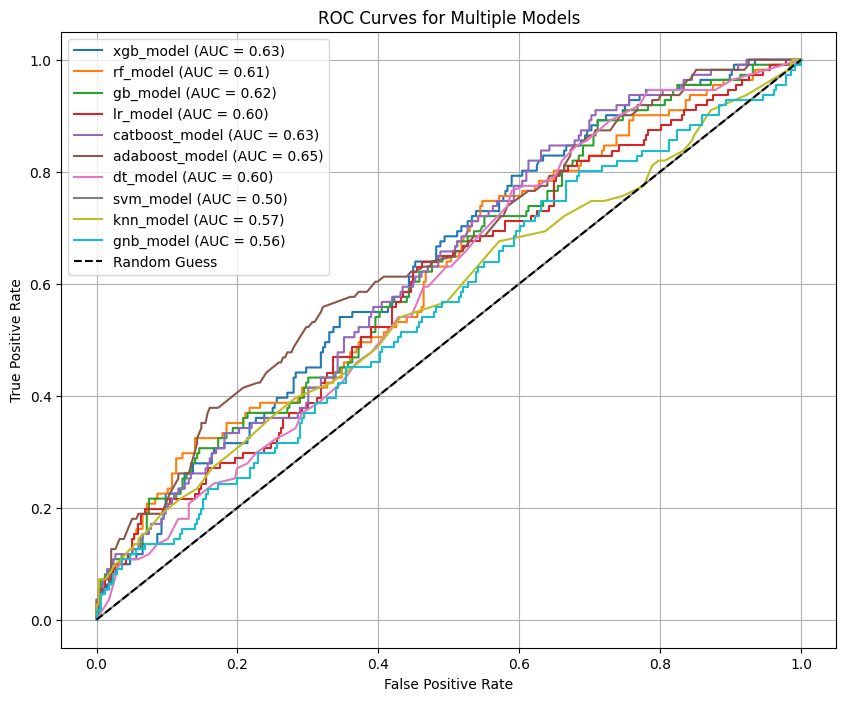

In [63]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import os
from google.colab import drive

# Ensure y_test is a Series
if isinstance(y_test_encoded, pd.DataFrame):
    y_test_series = y_test_encoded.iloc[:, 0]
else:
    y_test_series = y_test_encoded

plt.figure(figsize=(10, 8))

for model_name, model in loaded_models.items():
    try:
        # Some models (like SVM with probability=False) might not have predict_proba
        if hasattr(model, "predict_proba"):
            y_probs = model.predict_proba(X_test_encoded)[:, 1]
        elif hasattr(model, "decision_function"):
             # For models like SVM that have decision_function but not predict_proba
             # Note: This may require calibration for better probability estimates
             y_probs = model.decision_function(X_test_encoded)
        else:
            print(f"Model {model_name} does not have predict_proba or decision_function.")
            continue

        fpr, tpr, thresholds = roc_curve(y_test_series, y_probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    except Exception as e:
        print(f"Could not plot ROC curve for {model_name}: {e}")


plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiple Models')
plt.legend()
plt.grid(True)

# Save the plot to Google Drive as SVG
drive_folder_path = '/content/drive/MyDrive/NIR dataset'
# Ensure the directory exists
os.makedirs(drive_folder_path, exist_ok=True)
plot_save_path = os.path.join(drive_folder_path, 'roc_curves.svg')
plt.savefig(plot_save_path, format='svg')
print(f"ROC curves plot saved successfully to {plot_save_path}")

plt.show()

In [69]:
import pandas as pd
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, average_precision_score
)

# Ensure y_test is a Series
y_test_series = y_test_encoded.iloc[:, 0] if isinstance(y_test_encoded, pd.DataFrame) else y_test_encoded

# Ensure y_train is a Series
y_train_series = y_train_encoded.iloc[:, 0] if isinstance(y_train_encoded, pd.DataFrame) else y_train_encoded

evaluation_results = []

# Define custom thresholds for specific models
custom_thresholds = {
    'adaboost_model': 0.39,
    'xgb_model': 0.437
}

# Mapping from internal joblib names to human-readable names
model_name_map = {
    'xgb_model': "XGBoost",
    'adaboost_model': "AdaBoost",
    'gb_model': "Gradient Boosting",
    'catboost_model': "CatBoost",
    'svm_model': "SVM",
    'rf_model': "Random Forest",
    'lr_model': "Logistic Regression",
    'gnb_model': "Naive Bayes",
    'dt_model': "Decision Tree",
    'knn_model': "KNN"
}

for model_name, model in loaded_models.items():
    try:
        # Get predicted probabilities
        if hasattr(model, "predict_proba"):
            y_probs = model.predict_proba(X_test_encoded)[:, 1]
        elif hasattr(model, "decision_function"):
            y_probs = model.decision_function(X_test_encoded)
        else:
            print(f"Model {model_name} does not have predict_proba or decision_function. Skipping.")
            continue

        # Determine threshold
        if model_name in custom_thresholds:
            current_threshold = custom_thresholds[model_name]
        else:
            try:
                if hasattr(model, "predict_proba"):
                    y_train_probs_tune = model.predict_proba(X_train_encoded)[:, 1]
                elif hasattr(model, "decision_function"):
                    y_train_probs_tune = model.decision_function(X_train_encoded)
                else:
                    current_threshold = 0.5
                    y_train_probs_tune = None
                if y_train_probs_tune is not None:
                    current_threshold, _ = tune_threshold(model, X_train_encoded, y_train_series, beta=1)
            except Exception:
                current_threshold = 0.5

        # Apply threshold
        y_test_pred = (y_probs >= current_threshold).astype(int)

        # Metrics
        acc = accuracy_score(y_test_series, y_test_pred)
        prec = precision_score(y_test_series, y_test_pred, zero_division=0)
        rec = recall_score(y_test_series, y_test_pred, zero_division=0)
        f1 = f1_score(y_test_series, y_test_pred, zero_division=0)
        roc_auc = roc_auc_score(y_test_series, y_probs)
        pr_auc = average_precision_score(y_test_series, y_probs)

        evaluation_results.append({
            'Model Name': model_name_map.get(model_name, model_name),  # readable name
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-score': f1,
            'ROC AUC': roc_auc,
            'PR AUC': pr_auc
        })

    except Exception as e:
        print(f"Could not evaluate model {model_name}: {e}")
        evaluation_results.append({
            'Model Name': model_name_map.get(model_name, model_name),
            'Accuracy': 'Error',
            'Precision': 'Error',
            'Recall': 'Error',
            'F1-score': 'Error',
            'ROC AUC': 'Error',
            'PR AUC': 'Error'
        })

evaluation_df = pd.DataFrame(evaluation_results)
display(evaluation_df)


,Model Name,Accuracy,Precision,Recall,F1-score,ROC AUC,PR AUC
0,XGBoost,0.548098,0.312757,0.684685,0.429379,0.632092,0.365497
1,Random Forest,0.633110,0.317241,0.414414,0.359375,0.614717,0.386248
2,Gradient Boosting,0.595078,0.294118,0.450450,0.355872,0.616594,0.371280
3,Logistic Regression,0.501119,0.287879,0.684685,0.405333,0.595265,0.360306
4,CatBoost,0.628635,0.312925,0.414414,0.356589,0.627909,0.379487
5,AdaBoost,0.624161,0.345946,0.576577,0.432432,0.647523,0.404951
6,Decision Tree,0.577181,0.288043,0.477477,0.359322,0.596083,0.315289
7,SVM,0.248322,0.248322,1.000000,0.397849,0.500000,0.248322
8,KNN,0.519016,0.273913,0.567568,0.369501,0.566924,0.353284
9,Naive Bayes,0.474273,0.273723,0.675676,0.389610,0.556843,0.321033


In [70]:
# Save the evaluation table to Google Drive as a CSV file
drive_folder_path = '/content/drive/MyDrive/NIR dataset'
evaluation_save_path = os.path.join(drive_folder_path, 'model_evaluation_results.csv')

try:
    evaluation_df.to_csv(evaluation_save_path, index=False)
    print(f"Evaluation results table saved successfully to {evaluation_save_path}")
except Exception as e:
    print(f"Error saving evaluation results table: {e}")

Evaluation results table saved successfully to /content/drive/MyDrive/NIR dataset/model_evaluation_results.csv
